In [1]:
import pandas as pd
from astropy.units import Quantity, Unit
from astropy.cosmology import Planck15, FlatLambdaCDM
from astropy.coordinates import SkyCoord
from astropy.io import fits
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
import numpy as np
from tqdm import tqdm
import os
from random import randint
from subprocess import Popen, PIPE
import pickle

import xga
xga.NUM_CORES = 40
from xga.samples import ClusterSample
from xga.imagetools.misc import physical_rad_to_pix
from xga.sourcetools.misc import rad_to_ang, nh_lookup
from xga import CENSUS, COUNTRATE_CONV_SCRIPT
from xga.relations.clusters.LT import xcs_sdss_r500_52
from xga.products.relation import ScalingRelation
from xga.sourcetools.match import simple_xmm_match

%matplotlib inline

In [2]:
cosmo = FlatLambdaCDM(70, 0.3)
cosmo

FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)

**LOOK OUT FOR 101**

In [105]:
# chosen = ['LoVoCCS-32', 'LoVoCCS-18', 'LoVoCCS-54', 'LoVoCCS-91', 'LoVoCCS-112', 'LoVoCCS-111', 'LoVoCCS-106', 
#           'LoVoCCS-119', 'LoVoCCS-137', 'LoVoCCS-142', 'LoVoCCS-68', 'LoVoCCS-69', 'LoVoCCS-88', 'LoVoCCS-101', 
#           'LoVoCCS-132', 'LoVoCCS-89']

chosen = ['LoVoCCS-106', 'LoVoCCS-119', 'LoVoCCS-91', 'LoVoCCS-112', 'LoVoCCS-137', 'LoVoCCS-142', 'LoVoCCS-101', 
          'LoVoCCS-111', 'LoVoCCS-132', 'LoVoCCS-69', 'LoVoCCS-68', 'LoVoCCS-89', 'LoVoCCS-32', 'LoVoCCS-54', 
          'LoVoCCS-18', 'LoVoCCS-88']

/mnt/ufs18/home-218/turne540/code/XGA/xga/products/relation.py:827: UserWarning: The 'show_third_dim' argument should only be set to True if 'third_dim_info' was set on the creation of this scaling relation. Setting 'show_third_im' to False.
  warn("The 'show_third_dim' argument should only be set to True if 'third_dim_info' was set on the creation "


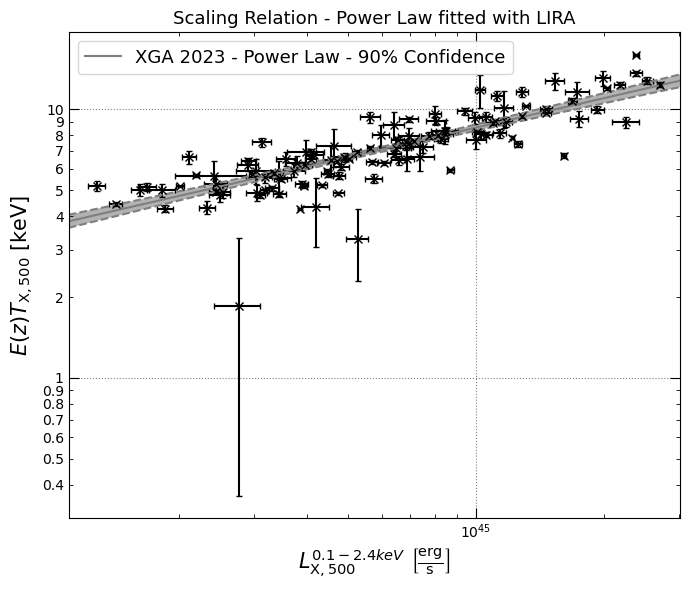

In [4]:
with open('lovisari_T500vsL_0.12.4_500_xgav0.4.xgarel', 'rb') as reado:
    t_l_rel = pickle.load(reado)
t_l_rel.view(figsize=(7, 6), grid_on=True)

In [5]:
samp = pd.read_csv('../../sample_files/lovoccs_southnorth.csv')
samp['LoVoCCS_name'] = samp['LoVoCCSID'].apply(lambda x: 'LoVoCCS-' + str(x))
chos_samp = samp[samp['LoVoCCS_name'].isin(chosen)]
chos_samp = chos_samp.reset_index(drop=True)
chos_samp

,name,MCXC,LoVoCCSID,ra,dec,redshift,L500,M500,R500,alt_name,other_names,Notes,sub_samp,LoVoCCS_name
0,MCXCJ0052.7-8015,J0052.7-8015,18,13.187083,-80.266389,0.1141,3.393306,3.9812,1.0783,RXCJ0052.7-8015,A2837,NaN,south,LoVoCCS-18
1,MCXCJ1130.3-1434,J1130.3-1434,32,172.581250,-14.583056,0.1068,2.605129,3.4062,1.0262,RXCJ1130.3-1434,A1285,NaN,south,LoVoCCS-32
2,MCXCJ1215.4-3900,J1215.4-3900,54,183.870833,-39.015278,0.1190,1.834651,2.7267,0.9489,RXCJ1215.4-3900,NaN,NaN,south,LoVoCCS-54
3,MCXCJ2321.5-4153,J2321.5-4153,68,350.389167,-41.898889,0.0894,1.625536,2.5863,0.9415,RXCJ2321.5-4153,A3998,losStr,south,LoVoCCS-68
4,MCXCJ0005.3+1612,J0005.3+1612,69,1.344167,16.210556,0.1164,1.579007,2.4929,0.9218,RXCJ0005.3+1612,A2703,B,north,LoVoCCS-69
5,MCXCJ2312.3-2130,J2312.3-2130,88,348.086250,-21.500556,0.1108,1.431443,2.3576,0.9065,RXCJ2312.3-2130,A2554,losStr,south,LoVoCCS-88
6,MCXCJ1511.3+0619,J1511.3+0619,89,227.847917,6.318889,0.0817,1.406968,2.3811,0.9183,A2033,A2033,NaN,south,LoVoCCS-89
7,MCXCJ0028.6-2338,J0028.6-2338,91,7.163750,-23.637222,0.1120,1.404549,2.3285,0.9024,RXCJ0028.6-2338,A42,NaN,south,LoVoCCS-91
8,MCXCJ0034.6-0208,J0034.6-0208,101,8.650000,-2.140000,0.0812,1.253723,2.2202,0.8972,RXCJ0034.6-0208,NaN,"DL,two maxima/E-W",south,LoVoCCS-101
9,MCXCJ1139.4-3327,J1139.4-3327,106,174.863750,-33.453889,0.1076,1.218610,2.1420,0.8789,RXCJ1139.4-3327,NaN,NaN,south,LoVoCCS-106


In [6]:
chos_samp.shape

(16, 14)

In [7]:
ls = Quantity(chos_samp['L500'].values*1e+44, 'erg/s')
z = chos_samp['redshift'].values
pred_t = t_l_rel.predict(ls, z, cosmo)
pred_t

<Quantity [5.46759186, 4.98447715, 4.36085903, 4.23488492, 4.13458329,
           4.00081867, 4.03333281, 3.97092581, 3.8685716 , 3.77929225,
           3.70096549, 3.68800995, 3.61805306, 3.62440271, 3.5273801 ,
           3.52450911] keV>

In [8]:
z

array([0.1141, 0.1068, 0.119 , 0.0894, 0.1164, 0.1108, 0.0817, 0.112 ,
       0.0812, 0.1076, 0.115 , 0.1186, 0.1176, 0.0788, 0.1153, 0.1043])

In [9]:
ls

<Quantity [3.393306e+44, 2.605129e+44, 1.834651e+44, 1.625536e+44,
           1.579007e+44, 1.431443e+44, 1.406968e+44, 1.404549e+44,
           1.253723e+44, 1.218610e+44, 1.162194e+44, 1.156778e+44,
           1.095941e+44, 1.044658e+44, 1.018847e+44, 1.001337e+44] erg / s>

In [61]:
flux = ((ls)/ (4*np.pi*(cosmo.luminosity_distance(z)**2))).to('erg/(s cm^2)')
flux

<Quantity [1.00908414e-11, 8.92795836e-12, 4.98364251e-12, 8.13859540e-12,
           4.49823931e-12, 4.53376353e-12, 8.52404824e-12, 4.34687717e-12,
           7.69474677e-12, 4.11002407e-12, 3.39816934e-12, 3.16515428e-12,
           3.05389834e-12, 6.83069184e-12, 2.96238417e-12, 3.61012189e-12] erg / (cm2 s)>

In [11]:
print(COUNTRATE_CONV_SCRIPT)
with open(COUNTRATE_CONV_SCRIPT, 'r') as c_script:
    script = c_script.read()

/mnt/ufs18/home-218/turne540/code/XGA/xga/xspec_scripts/cr_conv_calc.xcm


In [12]:
# This is one of XCS' recent observations of DES clusters
DONOR_OBS = "0864080901"

# Setting up paths to files required for simulating XMM spectrum - these will be filled in with ObsID
#  and instrument when required
arf_path = "xmm_resp/{o}_{i}_exp1arf.fits"
rmf_path = "xmm_resp/{o}_{i}_exp1rmf.fits"
spec_path = "xmm_resp/{o}_{i}_exp1spec.fits"

In [13]:
DONOR_OBS = "0880810201"

# Setting up paths to files required for simulating XMM spectrum - these will be filled in with ObsID
#  and instrument when required
arf_path = "xmm_resp/{o}_{i}_LoVoCCS-116_ra125.2575_dec7.866111111_ri0.0_ro0.09746580167775488_grpTrue_mincnt5.arf"
rmf_path = "xmm_resp/{o}_{i}_LoVoCCS-116_ra125.2575_dec7.866111111_ri0.0_ro0.09746580167775488_grpTrue_mincnt5.rmf"
spec_path = "xmm_resp/{o}_{i}_LoVoCCS-116_ra125.2575_dec7.866111111_ri0.0_ro0.09746580167775488_" \
            "grpTrue_mincnt5_spec.fits"

In [14]:
fits.open(rmf_path.format(o=DONOR_OBS, i='pn'))[1].header['FILTER']

'Thin1'

In [15]:
arfs_str = " ".join([arf_path.format(o=DONOR_OBS, i='pn'), 
                     arf_path.format(o=DONOR_OBS, i='mos1'), 
                     arf_path.format(o=DONOR_OBS, i='mos2')])
arfs_str = "{" + arfs_str + "}"
rmfs_str = " ".join([rmf_path.format(o=DONOR_OBS, i='pn'), 
                     rmf_path.format(o=DONOR_OBS, i='mos1'), 
                     rmf_path.format(o=DONOR_OBS, i='mos2')])
rmfs_str = "{" + rmfs_str + "}"

obs_str = "{" + " ".join([DONOR_OBS, DONOR_OBS, DONOR_OBS]) + "}"
inst_str = "{" + " ".join(['PN', 'MOS1', 'MOS2']) + "}"

lo_lims = "{0.5 0.1 0.01}"
hi_lims = "{2.0 2.4 100.0}"

In [98]:
# for row_ind, row in chos_samp.iterrows():
for chos in chosen:
    row = chos_samp[chos_samp['LoVoCCS_name'] == chos].iloc[0]
    row_ind = chos_samp[chos_samp['LoVoCCS_name'] == chos].index[0]
    nh = nh_lookup(Quantity([row['ra'], row['dec']], 'deg'))[0].value
    print(row['LoVoCCS_name'], nh, row['redshift'], flux[row_ind], pred_t[row_ind], 
          rad_to_ang(Quantity(row['R500'], 'Mpc'), row['redshift']))

LoVoCCS-32 0.0339 0.1068 8.927958363838426e-12 erg / (cm2 s) 4.984477151503441 keV 0.1458511582366462 deg
LoVoCCS-18 0.0551 0.1141 1.0090841428581856e-11 erg / (cm2 s) 5.467591860841938 keV 0.14464993458354683 deg
LoVoCCS-54 0.0672 0.119 4.983642505668761e-12 erg / (cm2 s) 4.360859033271748 keV 0.12273132956248965 deg
LoVoCCS-91 0.0141 0.112 4.346877172782819e-12 erg / (cm2 s) 3.970925814490584 keV 0.12302886224070338 deg
LoVoCCS-112 0.0195 0.1186 3.1651542758611836e-12 erg / (cm2 s) 3.688009945738122 keV 0.11210227674097237 deg
LoVoCCS-111 0.0171 0.115 3.3981693416340466e-12 erg / (cm2 s) 3.700965491806179 keV 0.11548616006952157 deg
LoVoCCS-106 0.053 0.1076 4.110024067325622e-12 erg / (cm2 s) 3.7792922538721023 keV 0.12410042875274586 deg
LoVoCCS-119 0.0477 0.1176 3.053898339113191e-12 erg / (cm2 s) 3.6180530591065243 keV 0.11176429127920536 deg
LoVoCCS-137 0.0666 0.1153 2.9623841651190474e-12 erg / (cm2 s) 3.5273801043878685 keV 0.11216755113931244 deg
LoVoCCS-142 0.0647 0.1043 3.61

In [49]:
wpimm_ctr = Quantity([[4.299, 1.193, 1.193], 
                      [3.811, 1.052, 1.052], 
                      [2.118, 0.5845, 0.5845], 
                      [3.484, 0.9659, 0.9659], 
                      [1.920, 0.5303, 0.5303], 
                      [1.937, 0.5327, 0.5327], 
                      [3.653, 1.007, 1.007], 
                      [1.849, 0.5108, 0.5108], 
                      [3.295, 0.9108, 0.9108], 
                      [1.747, 0.4833, 0.4833], 
                      [1.447, 0.3994, 0.3994], 
                      [1.344, 0.3710, 0.3710], 
                      [1.311, 0.3616, 0.3616], 
                      [2.953, 0.8079, 0.8079], 
                      [1.263, 0.3508, 0.3508], 
                      [1.553, 0.4259, 0.4259]], 'ct/s')
print(wpimm_ctr)

[[4.299  1.193  1.193 ]
 [3.811  1.052  1.052 ]
 [2.118  0.5845 0.5845]
 [3.484  0.9659 0.9659]
 [1.92   0.5303 0.5303]
 [1.937  0.5327 0.5327]
 [3.653  1.007  1.007 ]
 [1.849  0.5108 0.5108]
 [3.295  0.9108 0.9108]
 [1.747  0.4833 0.4833]
 [1.447  0.3994 0.3994]
 [1.344  0.371  0.371 ]
 [1.311  0.3616 0.3616]
 [2.953  0.8079 0.8079]
 [1.263  0.3508 0.3508]
 [1.553  0.4259 0.4259]] ct / s


In [79]:
exps = []
for ind in range(len(chos_samp)):
    e = Quantity(30000, 'ct') / wpimm_ctr[ind, :].sum()
    exps.append(max(e, Quantity(7000, 's')))
#     print(e)
print(sum(exps))

162923.16539828 s


In [106]:
for chos in chosen:
    row = chos_samp[chos_samp['LoVoCCS_name'] == chos].iloc[0]
    row_ind = chos_samp[chos_samp['LoVoCCS_name'] == chos].index[0]
    nh = nh_lookup(Quantity([row['ra'], row['dec']], 'deg'))[0].value
#     print(row['other_names'], row['LoVoCCS_name'], nh, flux[row_ind].to('1e-11 erg/s/cm^2').round(3), pred_t[row_ind].round(3), 
#           rad_to_ang(Quantity(row['R500'], 'Mpc'), row['redshift']).to('arcmin').round(3), exps[row_ind].to('ks'))
    
    print(row['other_names'], row['LoVoCCS_name'], flux[row_ind].to('1e-11 erg/s/cm^2').round(3), 
          wpimm_ctr[row_ind, 0], wpimm_ctr[row_ind, 1], pred_t[row_ind].round(3), wpimm_ctr[row_ind, :].sum().round(3)
          )

nan LoVoCCS-106 0.411 1e-11 erg / (cm2 s) 1.747 ct / s 0.4833 ct / s 3.779 keV 2.714 ct / s
A1023 LoVoCCS-119 0.305 1e-11 erg / (cm2 s) 1.311 ct / s 0.3616 ct / s 3.618 keV 2.034 ct / s
A42 LoVoCCS-91 0.435 1e-11 erg / (cm2 s) 1.849 ct / s 0.5108 ct / s 3.971 keV 2.871 ct / s
A2871 LoVoCCS-112 0.317 1e-11 erg / (cm2 s) 1.344 ct / s 0.371 ct / s 3.688 keV 2.086 ct / s
nan LoVoCCS-137 0.296 1e-11 erg / (cm2 s) 1.263 ct / s 0.3508 ct / s 3.527 keV 1.965 ct / s
nan LoVoCCS-142 0.361 1e-11 erg / (cm2 s) 1.553 ct / s 0.4259 ct / s 3.525 keV 2.405 ct / s
nan LoVoCCS-101 0.769 1e-11 erg / (cm2 s) 3.295 ct / s 0.9108 ct / s 3.869 keV 5.117 ct / s
A2988 LoVoCCS-111 0.34 1e-11 erg / (cm2 s) 1.447 ct / s 0.3994 ct / s 3.701 keV 2.246 ct / s
A1809 LoVoCCS-132 0.683 1e-11 erg / (cm2 s) 2.953 ct / s 0.8079 ct / s 3.624 keV 4.569 ct / s
A2703 LoVoCCS-69 0.45 1e-11 erg / (cm2 s) 1.92 ct / s 0.5303 ct / s 4.135 keV 2.981 ct / s
A3998 LoVoCCS-68 0.814 1e-11 erg / (cm2 s) 3.484 ct / s 0.9659 ct / s 4.235 

In [17]:
with tqdm(total=len(chos_samp), desc="Running Simulations") as onwards:
    for row_ind, row in chos_samp.iterrows():
        if not os.path.exists("sim_outputs/{}".format(row['LoVoCCS_name'])):
            os.makedirs("sim_outputs/{}".format(row['LoVoCCS_name']))
        
        outfile = os.getcwd()+"/sim_outputs/{}/sim.csv".format(row['LoVoCCS_name'])
        scfile = os.getcwd()+"/sim_outputs/{}/sim.xcm".format(row['LoVoCCS_name'])

        nh = nh_lookup(Quantity([row['ra'], row['dec']], 'deg'))[0].value
        temp = pred_t[row_ind].value
        par_vals = "{" + " ".join([str(nh), str(temp), '0.3', str(row['redshift']), '1']) + "}"
        
        cur_script = script.format(ab='angr', H0=cosmo.H0.value, q0=0., lamb0=cosmo.Ode0, rmf=rmfs_str, 
                                   arf=arfs_str, obs=obs_str, inst=inst_str, m="tbabs*apec", 
                                   pn="{nH kT Abundanc Redshift norm}", pv=par_vals, lll=lo_lims, 
                                   lul=hi_lims, redshift=str(row['redshift']), of=outfile, rid=randint(0, 1e+8))
        
        with open(scfile, 'w') as scripto:
            scripto.write(cur_script)
                
        out, err = Popen("xspec - " + scfile, shell=True, stdout=PIPE, stderr=PIPE).communicate()
        onwards.update(1)

Running Simulations: 100%|██████████| 16/16 [00:30<00:00,  1.93s/it]


In [40]:
obs_comb_exps = []
for row_ind, row in chos_samp.iterrows():
    outfile = os.getcwd() + "/sim_outputs/{}/sim.csv".format(row['LoVoCCS_name'])
    
    mcxc_lum = ls[row_ind].value
    
    if pred_t[row_ind].value <= 1.5:
        target_cnts = 1000
    elif pred_t[row_ind].value <= 3.0 and pred_t[row_ind].value > 1.5:
        target_cnts = 1500
    elif pred_t[row_ind].value <= 5.0 and pred_t[row_ind].value > 3:
        target_cnts = 2000
    else:
        target_cnts = 2500
    target_cnts *= 15
#     target_cnts = 10000
    
#     print(target_cnts)
    
    fak_info = pd.read_csv(outfile)

#     print(fak_info)
    
    sim_lum = fak_info.loc[1, 'Lx_{}PN'.format(DONOR_OBS)] * 10**44
#     print(sim_lum)
    lum_rat = mcxc_lum / sim_lum
    
    pn_sim_cnt_rate_124 = fak_info.loc[1, 'rate_{}PN'.format(DONOR_OBS)]
    pn_sim_cnt_rate_52 = fak_info.loc[0, 'rate_{}PN'.format(DONOR_OBS)]
    pn_cr_124_to_52 = pn_sim_cnt_rate_52/pn_sim_cnt_rate_124
    
    m1_sim_cnt_rate_124 = fak_info.loc[1, 'rate_{}MOS1'.format(DONOR_OBS)]
    m1_sim_cnt_rate_52 = fak_info.loc[0, 'rate_{}MOS1'.format(DONOR_OBS)]
    m1_cr_124_to_52 = m1_sim_cnt_rate_52/m1_sim_cnt_rate_124
    
    m2_sim_cnt_rate_124 = fak_info.loc[1, 'rate_{}MOS2'.format(DONOR_OBS)]
    m2_sim_cnt_rate_52 = fak_info.loc[0, 'rate_{}MOS2'.format(DONOR_OBS)]
    m2_cr_124_to_52 = m2_sim_cnt_rate_52/m2_sim_cnt_rate_124
        
    pn_cr = fak_info.loc[1, 'rate_{}PN'.format(DONOR_OBS)] * lum_rat * pn_cr_124_to_52
    m1_cr = fak_info.loc[1, 'rate_{}MOS1'.format(DONOR_OBS)] * lum_rat * m1_cr_124_to_52
    m2_cr = fak_info.loc[1, 'rate_{}MOS2'.format(DONOR_OBS)] * lum_rat * m2_cr_124_to_52
    
    print(pn_cr)
    print(m1_cr)
    print(m2_cr)
    print('\n\n')
#     rel_src = lovoccs_noclean[row['name']]
    
#     if len(rel_src.obs_ids) == 1:
#         o = rel_src.obs_ids[0]
#     else:
#         ra, dec = rel_src.ra_dec.value
#         matches = simple_xmm_match(ra, dec, Quantity(5, 'arcmin'))[0]
#         matches = matches[matches['dist'] == matches['dist'].min()]
#         o = matches['ObsID'].values[0]
    
#     cnt_pn = rel_src.get_counts('r500', rel_src.ra_dec, Quantity(0.5, 'keV'), Quantity(2.0, 'keV'), o, 'mos2')
    
    comb_exp = Quantity(target_cnts/(pn_cr+m1_cr+m2_cr), 's')  
#     comb_exp = Quantity((target_cnts/pn_cr)+(target_cnts/m1_cr)+(target_cnts/m2_cr), 's')
    
    obs_comb_exps.append(comb_exp)
    
#     print(comb_exp, '\n')

3.0506418573360037
0.9543174799646862
0.9408176194417225



2.8501001233821768
0.8799541836692707
0.8666534948472582



1.4478411244036262
0.45362317812900504
0.44725465696739813



2.717166849577059
0.8273353143540136
0.8140050431133596



1.4218256742457673
0.4377571749505318
0.4310385828195346



1.5126174491985418
0.46035784777070476
0.4528992426777445



2.73566020440088
0.8376376790688501
0.8245200983624715



1.4657218088801576
0.44507397891524597
0.4377866433552877



2.4528613262053964
0.7512508703847962
0.7394984999201268



1.2313346804069012
0.3818822125238781
0.3762275278315817



1.1342944306965108
0.3444217588345917
0.33877536067001623



1.0499167543563441
0.31915652475708756
0.31395093031055954



0.9305318581504192
0.2873434505144281
0.28299124320554



2.2359929823311426
0.6802200278991618
0.669228279663143



0.8537037557729263
0.26617434422874664
0.2623313051966257



1.0424187531292337
0.3248890071375236
0.32019166663808696





In [39]:
fak_info

,lo_en,hi_en,rate_0880810201PN,Lx_0880810201PN,rate_0880810201MOS1,Lx_0880810201MOS1,rate_0880810201MOS2,Lx_0880810201MOS2
0,0.50,2.0,229.083057,134.923880,71.397955,134.912050,70.365662,134.912050
1,0.10,2.4,304.761859,220.054888,88.448228,220.065244,85.585374,220.065244
2,0.01,100.0,355.333464,375.117117,106.952213,384.845121,104.492993,384.845121


In [44]:
print(chos_samp['LoVoCCS_name'].values)
print(obs_comb_exps)
sum(obs_comb_exps)

['LoVoCCS-18' 'LoVoCCS-32' 'LoVoCCS-54' 'LoVoCCS-68' 'LoVoCCS-69'
 'LoVoCCS-88' 'LoVoCCS-89' 'LoVoCCS-91' 'LoVoCCS-101' 'LoVoCCS-106'
 'LoVoCCS-111' 'LoVoCCS-112' 'LoVoCCS-119' 'LoVoCCS-132' 'LoVoCCS-137'
 'LoVoCCS-142']
[<Quantity 7582.22627668 s>, <Quantity 6526.41005104 s>, <Quantity 12772.9202673 s>, <Quantity 6883.09060302 s>, <Quantity 13096.88261041 s>, <Quantity 12366.67416624 s>, <Quantity 6821.56472231 s>, <Quantity 12773.66278573 s>, <Quantity 7607.24176617 s>, <Quantity 15079.58688713 s>, <Quantity 16506.26656101 s>, <Quantity 17825.05553516 s>, <Quantity 19988.45264598 s>, <Quantity 8367.17089318 s>, <Quantity 21704.38132397 s>, <Quantity 17777.78381533 s>]


<Quantity 203679.37091065 s>